In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

In [15]:
# Fetch data for MSFT from Yahoo Finance
ticker = 'MSFT'
start_date = '2020-01-01'
end_date = '2024-12-31'

# Download the data
msft_data = yf.download(ticker, start=start_date, end=end_date)

# Check the first few rows of the data
msft_data.head()

C:\Users\Theresa\AppData\Local\Temp\ipykernel_8464\108345505.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  msft_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2020-01-02,153.042282,153.147093,150.860326,151.289093,22622100
2020-01-03,151.136642,152.403898,150.603064,150.850807,21116200
2020-01-06,151.527359,151.594064,149.126242,149.669358,20813700
2020-01-07,150.145721,152.137116,149.897993,151.803637,21634100
2020-01-08,152.537292,153.213803,150.498254,151.432015,27746500


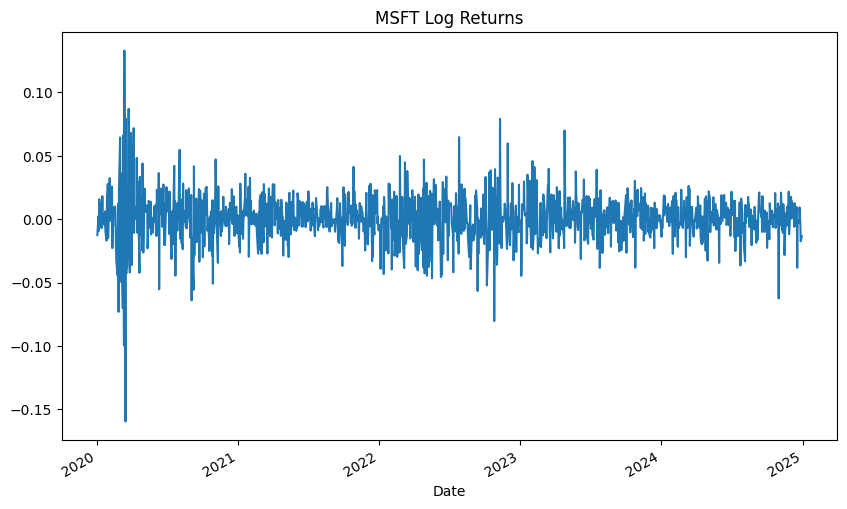

In [16]:
# Calculate daily log returns
msft_data['Log_Returns'] = np.log(msft_data['Close'] / msft_data['Close'].shift(1))

# Drop missing values (first row will be NaN due to shift)
msft_data = msft_data.dropna()

# Plot log returns to visualize the data
msft_data['Log_Returns'].plot(title='MSFT Log Returns', figsize=(10, 6))
plt.show()

msft_data.to_csv('msft_returns.csv')

In [10]:
# Define the EGARCH model (1,1)
model = arch_model(msft_data['Log_Returns'], vol='EGARCH', p=1, q=1)

# Fit the model
egarch_fit = model.fit(disp='off')

# Print the model summary
print(egarch_fit.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                3335.90
Distribution:                  Normal   AIC:                          -6663.79
Method:            Maximum Likelihood   BIC:                          -6643.25
                                        No. Observations:                 1256
Date:                Sun, Aug 10 2025   Df Residuals:                     1255
Time:                        10:23:12   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         9.1212e-04  5.095e-04      1.790  7.345e-02 

c:\Users\Theresa\.conda\envs\hackingsocks\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003697. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [11]:
# Forecast volatility for the next 30 days
forecast_horizon = 30
volatility_forecast = egarch_fit.forecast(horizon=forecast_horizon,method="bootstrap")

# Extract the forecasted volatility (standard deviation) from the model
forecasted_volatility = np.sqrt(volatility_forecast.variance.values[-1, :])

# Display the forecasted volatility
print("Forecasted Volatility for the next 30 days:")
print(forecasted_volatility)

Forecasted Volatility for the next 30 days:
[0.01413034 0.01425264 0.01434587 0.01444834 0.01451973 0.01466533
 0.01478242 0.01490705 0.01502972 0.01509516 0.01519696 0.0153544
 0.01546671 0.01557509 0.01565868 0.01572517 0.01581387 0.0159115
 0.01593019 0.01597027 0.01604704 0.01616008 0.01618517 0.01624143
 0.01631017 0.01636277 0.01642433 0.01646241 0.01655391 0.01656085]


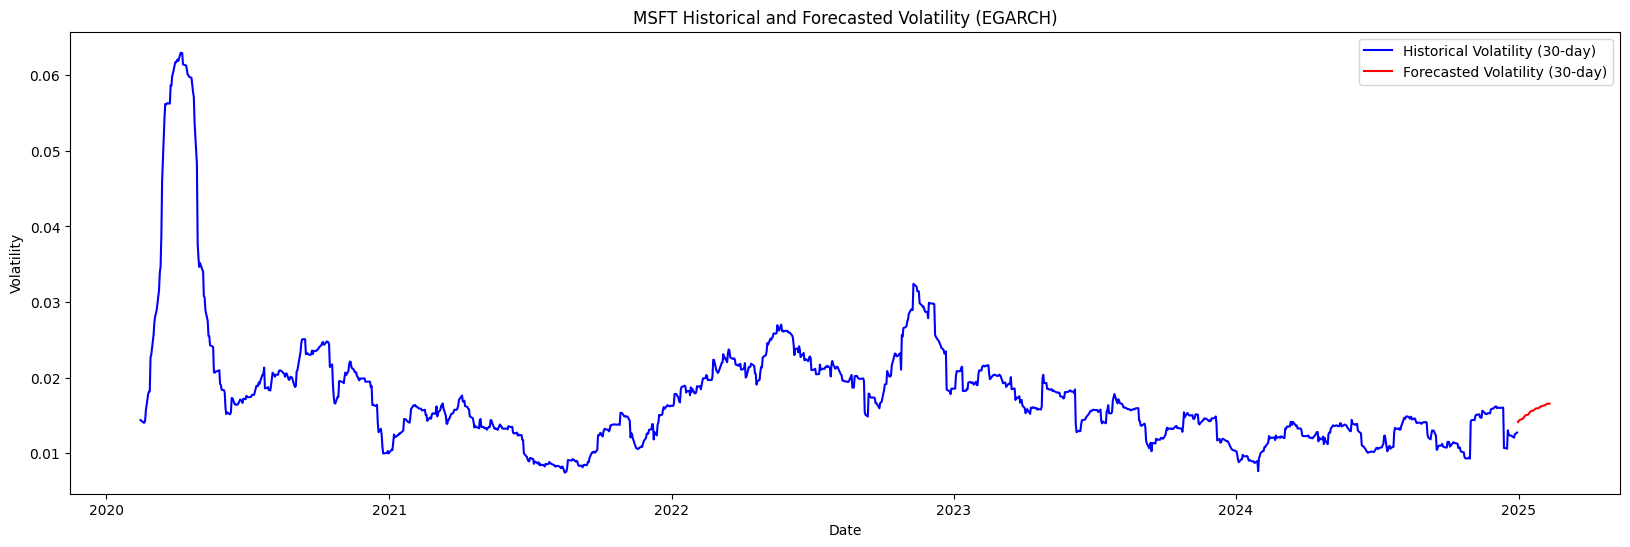

In [12]:
# Plot the historical and forecasted volatility
plt.figure(figsize=(20, 6))

# Historical volatility (rolling 30-day standard deviation of log returns)
historical_volatility = msft_data['Log_Returns'].rolling(window=30).std()

# Plot historical volatility
plt.plot(historical_volatility, label='Historical Volatility (30-day)', color='blue')

# Plot forecasted volatility (append to the end of historical data)
future_dates = pd.date_range(msft_data.index[-1], periods=forecast_horizon+1, freq='B')[1:]
forecast_volatility_series = pd.Series(forecasted_volatility, index=future_dates)

# Plot forecasted volatility
plt.plot(forecast_volatility_series, label='Forecasted Volatility (30-day)', color='red')

# Add labels and legend
plt.title('MSFT Historical and Forecasted Volatility (EGARCH)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()